**Description**: Tries to answer [my answer on
stats.stackexchange.com](https://stats.stackexchange.com/q/611877/337906) by training
BERT on real classification datasets. This experiment suggests that training on test set
features (no labels) can be okay.

**Estimated runtime**: ~30 minutes on a Google Colab GPU or TPU. Eternity on CPU.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import permutation_test
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

# Individual analysis

In [2]:
# dataset = "ag_news"
# dataset = "enron_spam"
# dataset = "amazon_counterfactual_en"
# dataset = "yelp_review_full"
# dataset = "craigslist_bargains"
# dataset = "emotion"
# dataset = "ethos"
# dataset = "yahoo_answers_topics"
# dataset = "trec"
# dataset = "mtop_domain"
# dataset = "clickbait_notclickbait_dataset"
# dataset = "financial_phrasebank"
# dataset = "app_reviews"
dataset = "rotten_tomatoes"

df = pd.read_csv(os.path.join("accuracies", f"{dataset}.csv"))
print(df.describe().round(3))

         base   extra    test
count  30.000  30.000  30.000
mean    0.711   0.759   0.752
std     0.071   0.055   0.066
min     0.545   0.620   0.610
25%     0.659   0.728   0.711
50%     0.722   0.768   0.755
75%     0.754   0.784   0.799
max     0.830   0.875   0.875


In [5]:
permutation_test(
    data=(df["test"], df["extra"]),
    statistic=lambda x, y: np.mean(x - y),
    alternative="greater",  # acc_test (unfair) > acc_extra (fair)
    permutation_type="samples",  # paired observations
    n_resamples=10_000,
).pvalue

0.7061293870612939

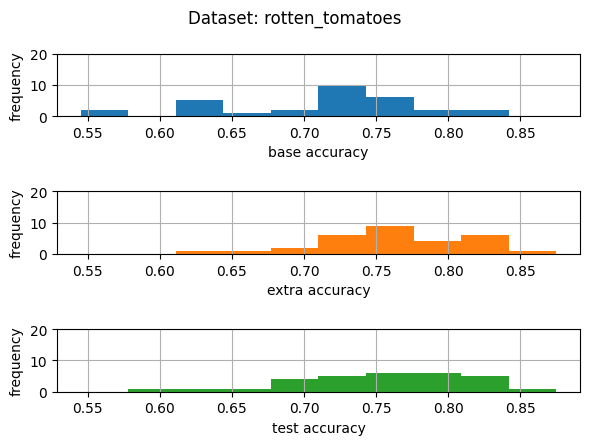

In [4]:
bins = 10

fig, axes = plt.subplots(
    nrows=len(df.columns), ncols=1, figsize=(6, len(df.columns) * 1.5)
)

axes: list[plt.Axes]

x_common_min = df.min().min()
x_common_max = df.max().max()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Plot histograms for each column
for i, column in enumerate(df.columns):
    column: str
    df[column].hist(
        bins=bins, ax=axes[i], range=(x_common_min, x_common_max), color=colors[i]
    )
    axes[i].set_ylim((0, 20))
    axes[i].set_xlabel(f"{column} accuracy")
    axes[i].set_ylabel("frequency")

fig.suptitle(f"Dataset: {dataset}", fontsize=12)
plt.tight_layout()
plt.subplots_adjust(hspace=1.2)

In [6]:
pvals = [
    0.65,
    0.63,
    0.58,
    0.09,
    0.84,
    0.78,
    0.18,
    0.9988,
    0.28,
    0.86,
    0.86,
    0.29,
    0.09,
    0.71,
]
fdrcorrection(pvals)

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([0.92615385, 0.92615385, 0.92615385, 0.63      , 0.92615385,
        0.92615385, 0.812     , 0.9988    , 0.812     , 0.92615385,
        0.92615385, 0.812     , 0.63      , 0.92615385]))

# Meta-analysis

In [7]:
_dfs = []
for accuracy_csv in sorted(os.listdir("accuracies")):
    _df = pd.read_csv(os.path.join("accuracies", accuracy_csv))
    _df["dataset"] = accuracy_csv.removesuffix(".csv")
    _dfs.append(_df)
accuracy_df = pd.concat(_dfs)
accuracy_df = accuracy_df[["dataset", "base", "extra", "test"]]

In [8]:
num_test = 200  # taken from bert/run.ipynb
num_correct_df = (accuracy_df.copy()[["base", "extra", "test"]] * num_test).astype(int)
num_correct_df["dataset"] = accuracy_df["dataset"].copy()
num_correct_df = num_correct_df[["dataset", "base", "extra", "test"]]
num_correct_df

,dataset,base,extra,test
0,ag_news,142,173,175
1,ag_news,146,176,172
2,ag_news,147,164,167
3,ag_news,159,164,168
4,ag_news,153,169,165
...,...,...,...,...
25,yelp_review_full,57,65,63
26,yelp_review_full,62,76,70
27,yelp_review_full,54,63,45
28,yelp_review_full,52,73,65


In [9]:
accuracy_df["diff"] = accuracy_df["test"] - accuracy_df["extra"]
accuracy_df["control"] = accuracy_df["extra"] - accuracy_df["base"]

In [10]:
sns.set_theme(style="darkgrid")

### Does pretraining help?

In [11]:
(accuracy_df
 .groupby("dataset")
 ["control"]
 .describe()
 [["mean", "std"]]
 .round(3)
)

,mean,std
dataset,,
ag_news,0.109,0.047
amazon_counterfactual_en,0.200,0.171
app_reviews,-0.057,0.167
clickbait_notclickbait_dataset,0.012,0.023
craigslist_bargains,0.468,0.167
emotion,0.026,0.104
enron_spam,0.007,0.022
ethos,0.047,0.058
financial_phrasebank,0.112,0.071


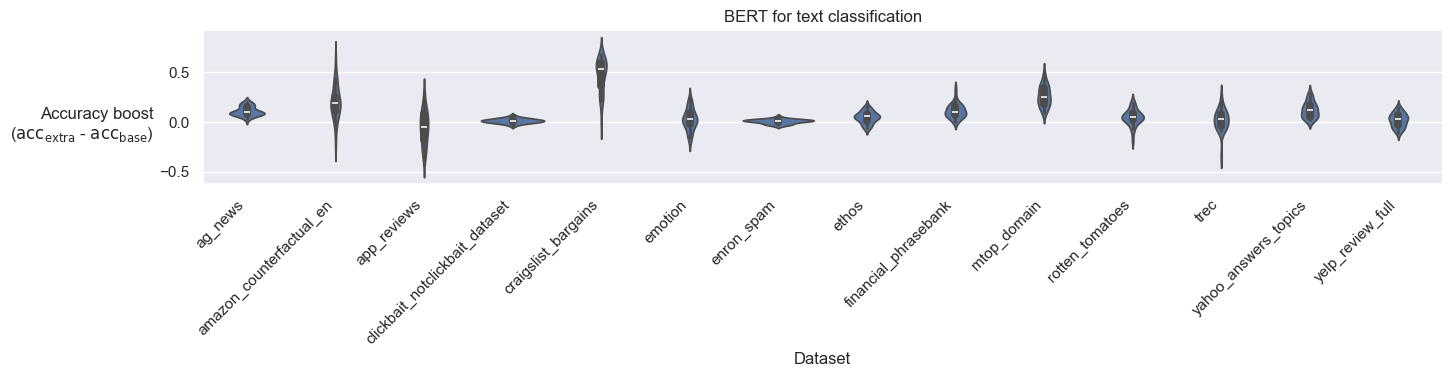

In [12]:
fig, axes = plt.subplots(figsize=(16, 2))
axes: plt.Axes
sns.violinplot(data=accuracy_df, x="dataset", y="control", ax=axes)
axes.set_title("BERT for text classification")

axes.yaxis.grid(True)
axes.set_xlabel("Dataset")
axes.set_ylabel(
    "Accuracy boost\n"
    "($\\text{acc}_\\text{extra}$ - $\\text{acc}_\\text{base}$)",
    rotation="horizontal",
    ha="right",
    va="top",
)
plt.xticks(rotation=45, ha="right")

plt.show()

### Does pretraining on test cause bias?

In [13]:
(accuracy_df
 .groupby("dataset")
 ["diff"]
 .describe()
 [["mean", "std"]]
 .round(3)
)

,mean,std
dataset,,
ag_news,-0.001,0.022
amazon_counterfactual_en,-0.007,0.126
app_reviews,0.038,0.151
clickbait_notclickbait_dataset,-0.004,0.022
craigslist_bargains,-0.024,0.128
emotion,-0.013,0.086
enron_spam,-0.000,0.016
ethos,0.007,0.041
financial_phrasebank,0.005,0.053


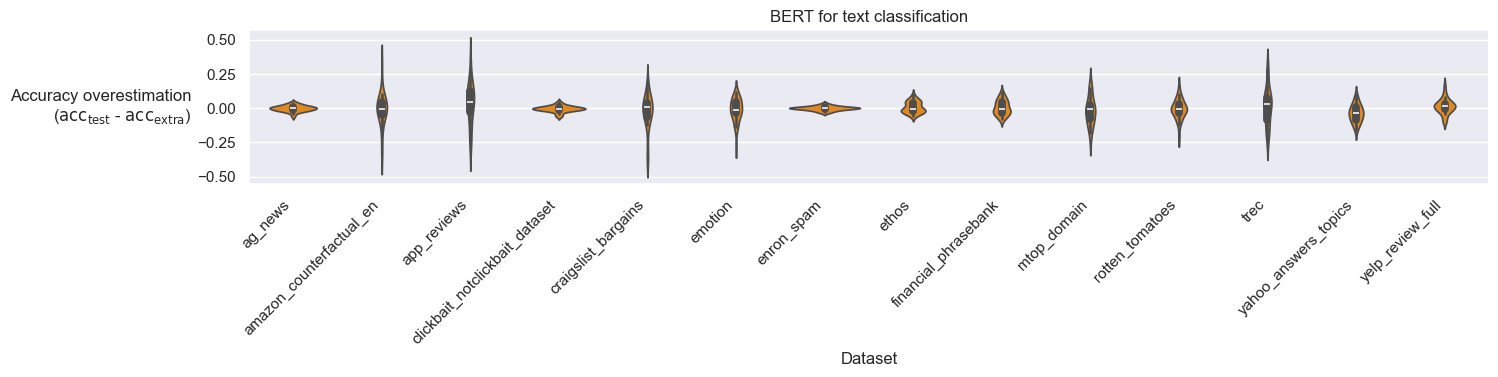

In [14]:
fig, axes = plt.subplots(figsize=(16, 2))
axes: plt.Axes
sns.violinplot(data=accuracy_df, x="dataset", y="diff", ax=axes, color="darkorange")
axes.set_title("BERT for text classification")

axes.yaxis.grid(True)
axes.set_xlabel("Dataset")
axes.set_ylabel(
    "Accuracy overestimation\n"
    "($\\text{acc}_\\text{test}$ - $\\text{acc}_\\text{extra}$)",
    rotation="horizontal",
    ha="right",
    va="center",
)
plt.xticks(rotation=45, ha="right")

plt.show()